In [1]:
#Importing packages

import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
%matplotlib inline

In [3]:
#Reading files from bucket

import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022');

In [18]:
#Opening files

#Present day, Pinatubo 
#From experiment 14
#Columb O3
o3_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Temperature
t_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/T.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Columb Sulfate
so4_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#AOD sulfate 
aod_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/D550_SO4.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Ozone layers
o3_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Sulfate in layers
so4_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/mmr_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'

#From experiment 16
#Columb O3
o3_cb_16 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16.cam.h0.197001-201412.nc'



#Present day, Krakatao
#Columb O3
o3_his = 's3://escience2022/Zhihong/NHISTvsls/cb_O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#AOD sulfate
aod_his = 's3://escience2022/Zhihong/NHISTvsls/D550_SO4.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#Sulfate in layers
so4_his = 's3://escience2022/Zhihong/NHISTvsls/mmr_SULFATE.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#O3 in layers
o3_his = 's3://escience2022/Zhihong/NHISTvsls/O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'



In [14]:
def north_multi_plot(data,yr):
    proj_plot = ccrs.Orthographic(0, 90)

    p = data.sel(time = data.time.dt.year.isin([yr])).squeeze().plot(x='lon', y='lat', 
                                                                     transform=ccrs.PlateCarree(),
                                                                     #aspect=anom.dims["lon"] / anom.dims["lat"],  # for a sensible figsize
                                                                     subplot_kws={"projection": proj_plot},
                                                                     col='time', col_wrap=6, robust=True, cmap='PiYG')
    # We have to set the map's options on all four axes
    for ax,i in zip(p.axes.flat,  data.time.sel(time = data.time.dt.year.isin([yr])).values):
        ax.coastlines()
        ax.set_title(i.strftime("%B %Y"), fontsize=18)

In [9]:
dso3= xr.open_dataset(s3.open(o3_14))
dso3.time.values;
ds_o3=dso3['O3']

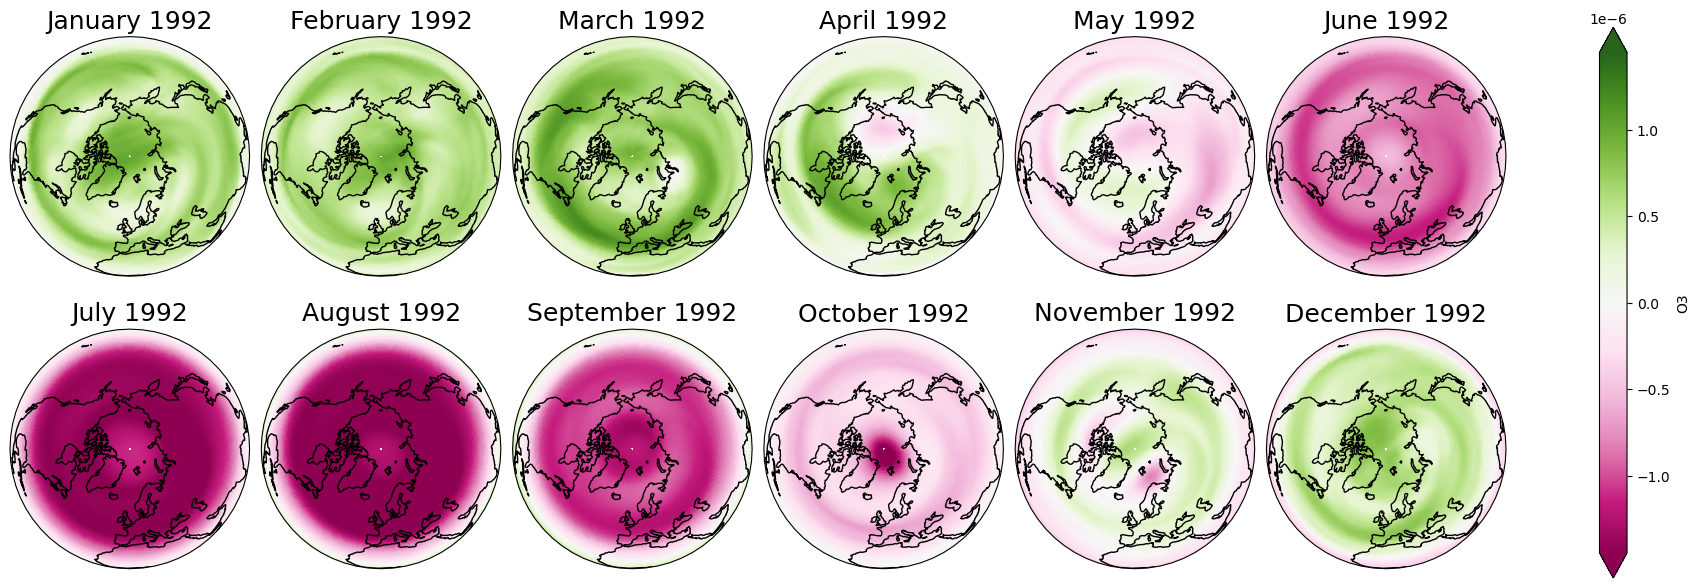

In [15]:
dso3_lev=ds_o3.sel(lev=3.6, method='nearest').drop('lev')

start = cftime.DatetimeNoLeap(1985,1,15)
end_prior_eruption = cftime.DatetimeNoLeap(1991,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

climatology = dso3_lev.sel(time=slice(start, end_prior_eruption)).groupby('time.year').mean('time',keep_attrs=True).mean('year')
#annual_mean = dso3_lev.groupby('time.year').mean('time')
anom=dso3_lev-climatology

north_multi_plot(anom,1992)

In [19]:
dso4= xr.open_dataset(s3.open(so4_14))
dso4.time.values;
ds_so4=dso4['mmr_SULFATE']

In [20]:
dso4_lev=ds_so4.sel(lev=24, method='nearest').drop('lev')

In [ ]:
#climatology = dso4_lev.sel(time=slice(start, end_prior_eruption)).groupby('time.year').mean('time',keep_attrs=True).mean('year')
#annual_mean = dso3_lev.groupby('time.year').mean('time')
#anom=dso4_lev-climatology

north_multi_plot(dso4_lev,1992)